In [80]:
#If using google colab
#from google.colab import drive
#drive.mount('/content/drive')

#from google.colab import files
#%cd "/content/drive/MyDrive/Colab Notebooks"

In [1]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from os import path
sns.set()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import calendar
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline
import time
import os

In [2]:
from config import Config

In [3]:
# ['Reddit', 'iSarcasm']
cfg = Config('iSarcasm')
dataset = cfg.dataset
file_path = cfg.input_file_path
comment_col_name = cfg.comment_col_name
label_col_name = cfg.label_col_name

In [4]:
dataset

'iSarcasmEval'

In [5]:
file_path

'..\\data\\iSarcasmEval\\train.csv'

In [7]:
sarcasm_df = pd.read_table(file_path, sep = ",")

## Data Analysis

In [8]:
sarcasm_df.head(10)

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0
5,5,"@jimrossignol I choose to interpret it as ""XD""...",1,It's a terrible name and the product sounds aw...,0.0,1.0,0.0,1.0,0.0,0.0
6,6,Why would Alexa's recipe for Yorkshire pudding...,1,Great recipe from Alexa,0.0,1.0,0.0,0.0,0.0,1.0
7,7,someone hit me w a horse tranquilizer istg ive...,1,Simply “I’m miserable.”,1.0,0.0,0.0,0.0,0.0,0.0
8,8,Loving season 4 of trump does America. Funnies...,1,this last year of trumps presidency is not goi...,1.0,0.0,0.0,0.0,0.0,0.0
9,9,Holly Arnold ??? Who #ImACeleb #MBE nope not ...,1,"Holly Arnold seem like a nice lady, just feel ...",1.0,0.0,0.0,0.0,0.0,1.0


In [9]:
# Data Pre-Processing
# Removing the null comments

sarcasm_df.dropna(subset=[comment_col_name], inplace=True)
sarcasm_df[comment_col_name] = sarcasm_df[comment_col_name].str.lower()
sarcasm_df[comment_col_name] = sarcasm_df[comment_col_name].str.replace('[^\w\s]','')

C:\Users\omars\AppData\Local\Temp\ipykernel_2548\1140158327.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  sarcasm_df[comment_col_name] = sarcasm_df[comment_col_name].str.replace('[^\w\s]','')


In [10]:
# Converting the timestamp into DateTime object
#sarcasm_df.created_utc = pd.to_datetime(sarcasm_df.created_utc)
#sarcasm_df.info()

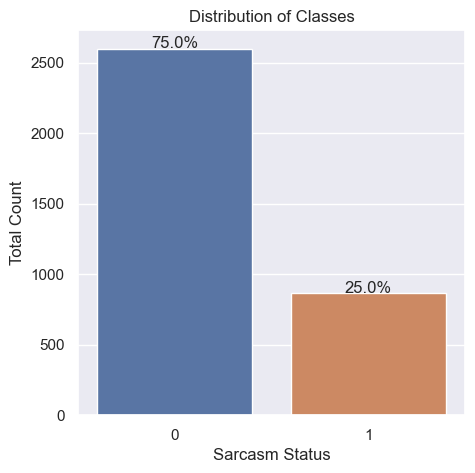

In [11]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x=label_col_name,  data= sarcasm_df) 
ax.set(title = "Distribution of Classes", xlabel="Sarcasm Status", ylabel = "Total Count")
total = float(len(sarcasm_df ))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
           height + 3,
           '{:1.1f}%'.format((height/total)*100),
            ha="center") 
plt.show()

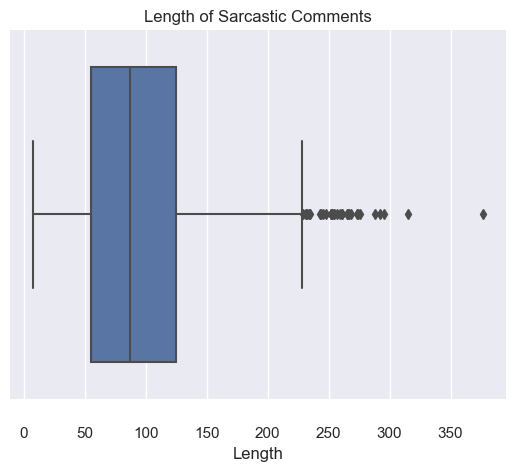

In [12]:
# Distribution of the lenth of Sarcastic comments
sns.boxplot(x= sarcasm_df.loc[sarcasm_df[label_col_name] == 1, comment_col_name].str.len()).set(title = 'Length of Sarcastic Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

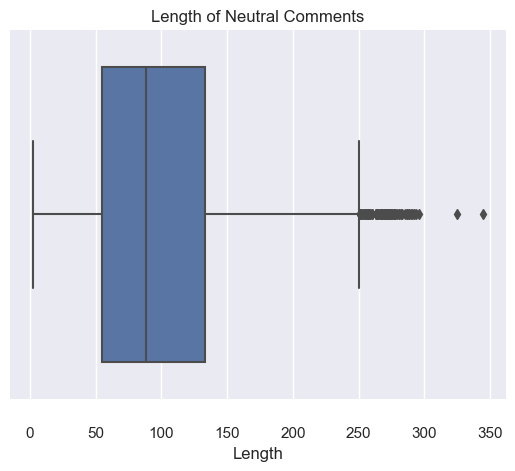

In [13]:
# Distribution of the lenth of Neutral comments
sns.boxplot(x= sarcasm_df.loc[sarcasm_df[label_col_name] == 0, comment_col_name].str.len()).set(title = 'Length of Neutral Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

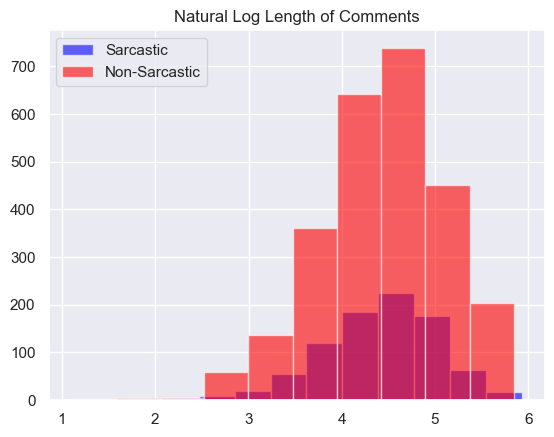

In [14]:
sarcasm_df['log_comment'] = sarcasm_df[comment_col_name].apply(lambda text: np.log1p(len(text)))
sarcasm_df[sarcasm_df[label_col_name]==1]['log_comment'].hist(alpha=0.6,label='Sarcastic', color = 'blue')
sarcasm_df[sarcasm_df[label_col_name]==0]['log_comment'].hist(alpha=0.6,label='Non-Sarcastic', color = 'red')
plt.legend()
plt.title('Natural Log Length of Comments')
plt.show()

C:\Users\omars\AppData\Local\Temp\ipykernel_2548\2284420690.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b= False)


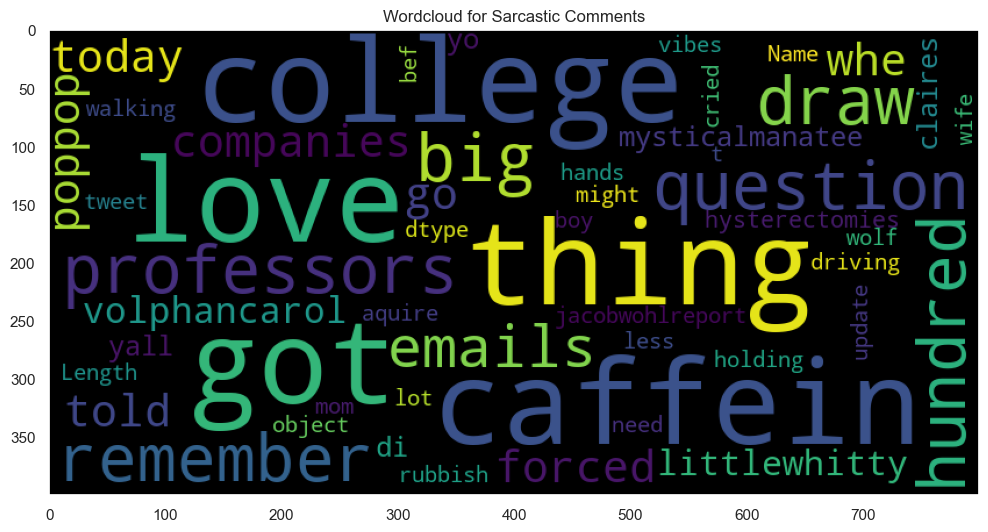

In [15]:
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(12, 12))
wordcloud.generate(str(sarcasm_df.loc[sarcasm_df[label_col_name] == 1, comment_col_name]))
plt.grid(b= False)
plt.title("Wordcloud for Sarcastic Comments")
plt.imshow(wordcloud);

C:\Users\omars\AppData\Local\Temp\ipykernel_2548\2827342884.py:3: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b= False)


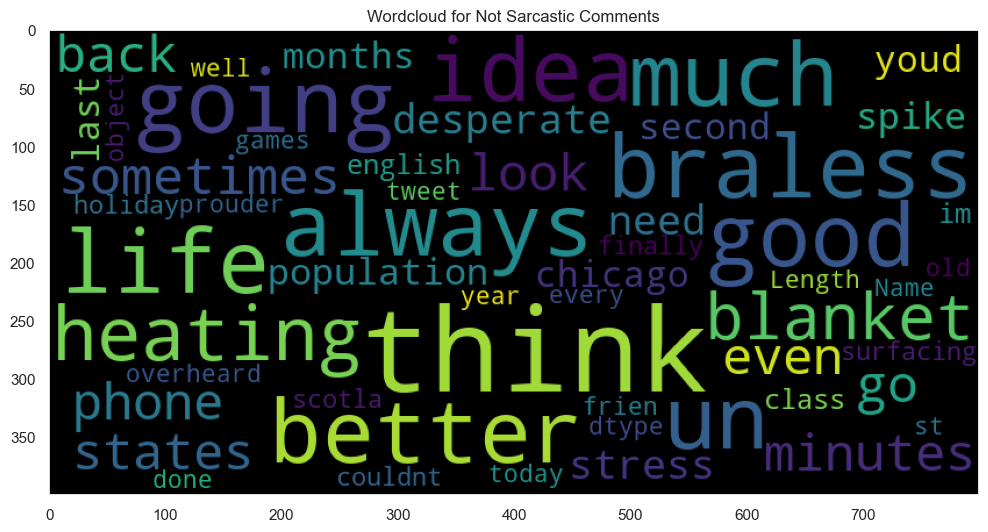

In [16]:
plt.figure(figsize=(12, 12))
wordcloud.generate(str(sarcasm_df.loc[sarcasm_df[label_col_name] == 0, comment_col_name]))
plt.grid(b= False)
plt.title("Wordcloud for Not Sarcastic Comments")
plt.imshow(wordcloud);

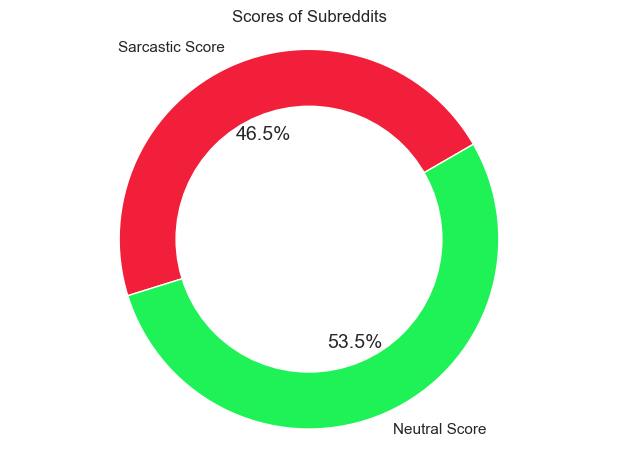

In [17]:
labels = ['Sarcastic Score', 'Neutral Score']
sizes = [3235069, 3725113]
#colors
colors = ['#F21F3B', '#1FF257']
 
plt.rcParams.update({'font.size': 14})
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=30)
ax1.set_title("Scores of Subreddits")
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 
plt.tight_layout()
plt.show()

In [18]:
#Comparison of comment with its parent comment can only be done in the Reddit dataset 
if dataset == "Reddit":
    sarcasm_comm_len = np.array(sarcasm_df.loc[sarcasm_df[label_col_name] == 1][comment_col_name].str.len())
    parent_comm_len = np.array(sarcasm_df.loc[sarcasm_df[label_col_name] == 1]['parent_comment'].str.len())
    ratio_len = np.array((sarcasm_df.loc[sarcasm_df[label_col_name] == 1][comment_col_name].str.len())/(sarcasm_df.loc[sarcasm_df[label_col_name] == 1]['parent_comment'].str.len()))
    dataset_reddit = pd.DataFrame({'Comment Length': sarcasm_comm_len, 'Parent Comment Length': parent_comm_len, 'Ratio Length': ratio_len}, columns=['Comment Length', 'Parent Comment Length', 'Ratio Length'])
    ax = plt.axes()
    sns.scatterplot(data=dataset_reddit, x="Comment Length", y="Parent Comment Length",  size=ratio_len)
    ax.set_title("Comparing Sarcastic Comment Length with Parent Comment")
      # control x and y limits
    plt.ylim(0, 12000)
    plt.xlim(0, 800)
    plt.show()

In [19]:
if dataset == "Reddit":
    top_reddits=sarcasm_df['subreddit'].value_counts()[:5].index.tolist()
    subreddit = pd.DataFrame()
    subreddit['subreddit'] = top_reddits
    subreddit['sarcastic'] = np.nan
    subreddit['natural'] = np.nan
    subreddit['total'] = np.nan
  # Calculating the count of Sarcastic and Natural comments for the top 5 subreddits 
    for i in range(len(top_reddits)):
        temp = sarcasm_df.loc[sarcasm_df['subreddit'] == subreddit.subreddit.iloc[i]]
        length = len(temp)
        count_sarcastic = len(temp.loc[temp[label_col_name] == 1])
        subreddit.sarcastic.iloc[i] = count_sarcastic
        subreddit.natural.iloc[i] = length - count_sarcastic
        subreddit.total.iloc[i] = length
        # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 5))
      
    # Plot the total comments for the subreddits
    sns.barplot(x="total", y="subreddit", data=subreddit,
            label="Total", color="b")
    # Plot the total sarcastic comments for the subreddits
    sns.barplot(x="sarcastic", y="subreddit", data=subreddit,
            label="Sarcastic Comments", color="r")
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set( ylabel="Subreddits",
       xlabel="Total number of comments")
    sns.despine(left=True, bottom=True)

## Data Preprocessing
* Lemmatization
* Stop words removal

In [20]:
sarcasm_df.head(10)

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question,log_comment
0,0,the only thing i got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0,4.060443
1,1,i love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0,4.836282
2,2,remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0,5.424950
3,3,today my poppop told me i was not forced to go...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0,4.343805
4,4,volphancarol littlewhitty mysticalmanatee i di...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0,5.241747
5,5,jimrossignol i choose to interpret it as xd th...,1,It's a terrible name and the product sounds aw...,0.0,1.0,0.0,1.0,0.0,0.0,5.446737
6,6,why would alexas recipe for yorkshire pudding ...,1,Great recipe from Alexa,0.0,1.0,0.0,0.0,0.0,1.0,4.477337
7,7,someone hit me w a horse tranquilizer istg ive...,1,Simply “I’m miserable.”,1.0,0.0,0.0,0.0,0.0,0.0,5.164786
8,8,loving season 4 of trump does america funniest...,1,this last year of trumps presidency is not goi...,1.0,0.0,0.0,0.0,0.0,0.0,4.499810
9,9,holly arnold who imaceleb mbe nope not sure ...,1,"Holly Arnold seem like a nice lady, just feel ...",1.0,0.0,0.0,0.0,0.0,1.0,4.442651


In [21]:
# drop every column except label and comment itself
sarcasm_data = sarcasm_df[[label_col_name, comment_col_name]]

In [22]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
#nltk.download('all')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\omars\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\omars\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\omars\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\omars\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\omars\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [23]:
sarcasm_data.head(10)

,sarcastic,tweet
0,1,the only thing i got from college is a caffein...
1,1,i love it when professors draw a big question ...
2,1,remember the hundred emails from companies whe...
3,1,today my poppop told me i was not forced to go...
4,1,volphancarol littlewhitty mysticalmanatee i di...
5,1,jimrossignol i choose to interpret it as xd th...
6,1,why would alexas recipe for yorkshire pudding ...
7,1,someone hit me w a horse tranquilizer istg ive...
8,1,loving season 4 of trump does america funniest...
9,1,holly arnold who imaceleb mbe nope not sure ...


In [24]:
#def to_doc(words:tuple) -> spacy.tokens.Doc:
    # Create SpaCy documents by joining the words into a string
    #return nlp(' '.join(words))

#def remove_stops(doc) -> list:
    # Filter out stop words by using the `token.is_stop` attribute
    

#def lemmatize(doc) -> list:
    # Take the `token.lemma_` of each non-stop word 

def lemmatize_text(doc):
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(doc)]
    #spacy alternative
    #return [j.lemma_ for token in doc for j in nlp(token)]

def remove_stops(doc) -> list:
    # Filter out stop words by using the stop_words attribute
    return [token for token in doc if token not in stop_words]
    #spacy alternative
    #return [token.text for token in doc if not token.is_stop]

In [25]:
sarcasm_data['text_lemmatized'] = sarcasm_data[comment_col_name].apply(lemmatize_text)

# apply removing stop words to all
sarcasm_data['removed_stop_words'] = sarcasm_data.text_lemmatized.apply(remove_stops)

C:\Users\omars\AppData\Local\Temp\ipykernel_2548\740297030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sarcasm_data['text_lemmatized'] = sarcasm_data[comment_col_name].apply(lemmatize_text)
C:\Users\omars\AppData\Local\Temp\ipykernel_2548\740297030.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sarcasm_data['removed_stop_words'] = sarcasm_data.text_lemmatized.apply(remove_stops)


In [26]:
sarcasm_data.head(10)

,sarcastic,tweet,text_lemmatized,removed_stop_words
0,1,the only thing i got from college is a caffein...,"[the, only, thing, i, got, from, college, is, ...","[thing, got, college, caffeine, addiction]"
1,1,i love it when professors draw a big question ...,"[i, love, it, when, professor, draw, a, big, q...","[love, professor, draw, big, question, mark, n..."
2,1,remember the hundred emails from companies whe...,"[remember, the, hundred, email, from, company,...","[remember, hundred, email, company, covid, sta..."
3,1,today my poppop told me i was not forced to go...,"[today, my, poppop, told, me, i, wa, not, forc...","[today, poppop, told, wa, forced, go, college,..."
4,1,volphancarol littlewhitty mysticalmanatee i di...,"[volphancarol, littlewhitty, mysticalmanatee, ...","[volphancarol, littlewhitty, mysticalmanatee, ..."
5,1,jimrossignol i choose to interpret it as xd th...,"[jimrossignol, i, choose, to, interpret, it, a...","[jimrossignol, choose, interpret, xd, universa..."
6,1,why would alexas recipe for yorkshire pudding ...,"[why, would, alexas, recipe, for, yorkshire, p...","[would, alexas, recipe, yorkshire, pudding, bh..."
7,1,someone hit me w a horse tranquilizer istg ive...,"[someone, hit, me, w, a, horse, tranquilizer, ...","[someone, hit, w, horse, tranquilizer, istg, i..."
8,1,loving season 4 of trump does america funniest...,"[loving, season, 4, of, trump, doe, america, f...","[loving, season, 4, trump, doe, america, funni..."
9,1,holly arnold who imaceleb mbe nope not sure ...,"[holly, arnold, who, imaceleb, mbe, nope, not,...","[holly, arnold, imaceleb, mbe, nope, sure, oh,..."


In [27]:
sarcasm_data.to_csv(cfg.preprocessed_file_path)